# **Machine Learning Model to Predict COVID-19 Misinformation on Twitter**



In [ ]:
# utils
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# natural language packages
# (https://www.nltk.org/)
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# machine learning packages
# (https://scikit-learn.org/stable/)
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# xgboost (https://xgboost.readthedocs.io/en/stable/python/index.html)
import xgboost as xgb
from xgboost import XGBClassifier

# ignore futurewarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mount Google Drive and set working directory.

In [ ]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

# set working directory to appropriate folder in google drive
%cd drive/MyDrive/Machine Learning Project

Mounted at /content/drive
/content/drive/MyDrive/Machine Learning Project


## **Load Dataset**

In [ ]:
# read in final version of twitter dataset
data = pd.read_csv('data/final_twitter_data.csv')
data.head()

,id,date,tweet,username,lang,replyCount,likeCount,retweetCount,tweet_class
0,1.265080e+18,2020-05-26 00:56:04+00:00,"Ian Haydon, who is participating in a vaccine ...",AC360,en,22,193,63,fake news
1,1.252420e+18,2020-04-21 02:16:11+00:00,Gachibowli Sports Tower turns Covid hospital\n...,BRSparty,en,11,409,46,fake news
2,1.253760e+18,2020-04-24 19:04:33+00:00,"Protesters at state Capitol are chanting ""Wher...",sbauerAP,en,21,567,192,fake news
3,1.237780e+18,2020-03-11 16:26:53+00:00,"🚨 BREAKING 🚨\n\n""We have therefore made the as...",WHO,en,1972,51420,50128,ambiguous
4,1.270080e+18,2020-06-08 19:53:19+00:00,1/2\n\n@WHO recently published a summary of tr...,mvankerkhove,en,100,606,283,fake news


In [ ]:
# keep only relevent columns
data = data[['tweet', 'tweet_class']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17679 entries, 0 to 17678
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        17679 non-null  object
 1   tweet_class  16881 non-null  object
dtypes: object(2)
memory usage: 276.4+ KB


In [ ]:
# drop tweets without a label/class
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16881 entries, 0 to 17678
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        16881 non-null  object
 1   tweet_class  16881 non-null  object
dtypes: object(2)
memory usage: 395.6+ KB


In [ ]:
data['tweet_class'].value_counts() # count of tweet classes in dataset

true news    9004
fake news    7395
political     378
ambiguous     104
Name: tweet_class, dtype: int64

In [ ]:
# drop the political and ambiguous classes as they are not well represented in the dataset
dropindex = data[data['tweet_class'].isin(['political', 'ambiguous'])].index
data = data.drop(dropindex)
data['tweet_class'].value_counts() # count of tweet classes in dataset

true news    9004
fake news    7395
Name: tweet_class, dtype: int64

## **Clean and Process Tweets**

Createing a `clean_text` function to clean tweets.

In [ ]:
import re

def clean_text(text):
    pat1 = r'@[^ ]+' # [^ ]+
    pat2 = r'https?://[A-Za-z0-9./]+'
    pat3 = r'\'s'
    pat4 = r'\#\w+'
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'
    pat7 = r'\n'
    combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6, pat7)) # combines created regex patterns set above
    text = re.sub(combined_pat, ' ', text) # removes those regex patterns from text passed through the function
    text = re.sub(' +', ' ', text) # removes unwanted whitespace within cleaned tweet
    return text.strip() # returns the text and strips leading and trailing whitespace

data['cleaned_tweet'] = data['tweet'].apply(clean_text)
display(data['cleaned_tweet'][0:5])

0    Ian Haydon who is participating in a vaccine t...
1    Gachibowli Sports Tower turns Covid hospital T...
2    Protesters at state Capitol are chanting Where...
4    recently published a summary of transmission o...
5    on transmission from asymptomatic individuals ...
Name: cleaned_tweet, dtype: object

Process the text of the tweets by making all the text lowercase, removing stopwords, applying lemmatization and applying stemming.

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) # initiate the list of stop words to be removed
new_stop = ['via'] # identify any additional stop words to be considered
all_stop = stop.union(new_stop) # add those new stopwords to the already defined list of stop words

stemmer = SnowballStemmer('english') # initiate the stemmer to be used
lemma = WordNetLemmatizer() # initiate the lemmatizer to be applied to the tweet text

# now we will process the tweet text
data['processed_tweet'] = data['cleaned_tweet'].str.lower() # make the tweets all lowercase
data['processed_tweet'] = data['processed_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stop)])) # remove the set of stop words from the tweet data
data['processed_tweet'] = data['processed_tweet'].apply(lambda x: ''.join([lemma.lemmatize(y) for y in x])) # apply lemmatizer to tweet text
data['processed_tweet'] = data['processed_tweet'].apply(lambda x: ''.join([stemmer.stem(y) for y in x]))

## **Prepare Data for Machine Learning Models**

An encoder is used to create a binary representation of the target class, TF-IDF vectorization is applied to the tweet data, and train and test splits are set for the data. A 70/30 percent split was used for the train and test datasets respectively.

In [ ]:
# create binary numerical representation of tweet classes
Encoder = LabelEncoder()
data['class'] = Encoder.fit_transform(data['tweet_class'])

# x and y split
x = data['processed_tweet']
y = data['class']

# tfidf vectorization of x (tweet data)
tfidf_vect = TfidfVectorizer(max_features=7000) # the tfidf vectorizer is initiated and max number of tweet features is set
x_tfidf = tfidf_vect.fit_transform(x) # the tfidf vectorizer is used to transform the tweet data to the appropriate format

# split train and test data
train_x, test_x, train_y, test_y = model_selection.train_test_split(x_tfidf, y, test_size=0.3, stratify=y)

The following shows the shapes of the training and test datasets.

In [ ]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(11479, 7000)
(4920, 7000)
(11479,)
(4920,)


## **Using XGBoost to Make Class Predictions**

Multiple machine learning models are test to see which one is able to make misinformation predeictions the best.

In [ ]:
# set random seed for consistent results
np.random.seed(100)

#### XGBoost Model

In [ ]:
xgb.XGBClassifier().get_params() # view the parameters of the XGBoost classifier

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

First, grid search and cross validation methods will be used to identify the optimal version of the XGBoost classifier model.

In [14]:
# fit the training dataset on the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', booster='gbtree')

# gridsearch parameters and initiation
xgb_params = {'max_depth': [5, 10, 15, 20],
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'n_estimators': [100, 500, 1000]}

xgb = GridSearchCV(xgb, xgb_params, refit=True, cv=5, verbose=2)

# fitting the random forest model
xgb = xgb.fit(train_x, train_y)

# evaluate the pexgbormance of the model
print('\n', xgb.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   5.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   3.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   3.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   3.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   5.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  17.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  22.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  27.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  16.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  16.9s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=  35.1s
[CV] END ..learning_rate=0.1, max_depth=5, n_es

In [15]:
# setting up xgboost classifier model
xgbclf = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=500, objective='binary:logistic', booster='gbtree')

# training the xgboost model
xgbclf = xgbclf.fit(train_x, train_y)

# generating predictions from the trained model
predsxgb = xgbclf.predict(test_x)

# evaluate the performance of the model
print("XGBoost Model Accuracy Score:", round(accuracy_score(predsxgb, test_y)*100, 2))
print('\n', classification_report(predsxgb, test_y))

# 1 = True News, 0 = Fake News

XGBoost Model Accuracy Score: 94.74

               precision    recall  f1-score   support

           0       0.94      0.94      0.94      2220
           1       0.95      0.95      0.95      2700

    accuracy                           0.95      4920
   macro avg       0.95      0.95      0.95      4920
weighted avg       0.95      0.95      0.95      4920



Text(0.5, 1.0, 'XGBoost Classifier')

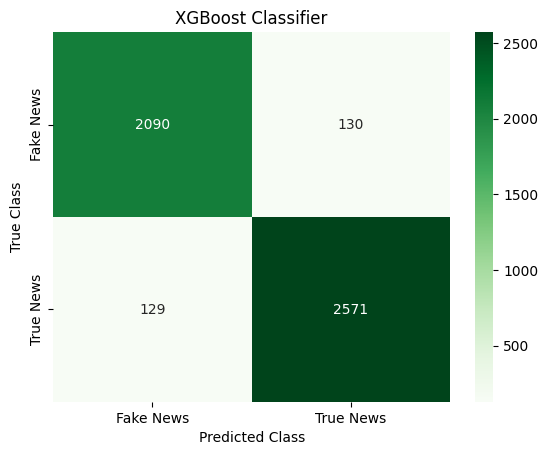

In [16]:
xgb_cm = confusion_matrix(predsxgb, test_y)
sns.heatmap(xgb_cm, annot=True, fmt='.0f',xticklabels = ["Fake News", "True News"] , yticklabels = ["Fake News", "True News"], cmap='Greens')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('XGBoost Classifier')

## **Save XGBoost Model for Deployment**

In [17]:
# save the XGBoost model as a pickle file
model_pkl_file = "xgboost_tweet_pred.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(xgbclf, file)